In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

save_kwargs = dict(dpi=300, transparent=True, bbox_inches="tight")

In [2]:
from pathlib import Path

def _get_n_changes(df):
    changed = (np.abs(df["head"].diff())> 0).astype(int)
    return changed


DIR = Path("salmon") / "io" / "2021-05-26-search"
responses = [pd.read_csv(f) for f in DIR.glob(f"*-1_responses.csv.zip")]
for k, _df in enumerate(responses):
    _df = _df[-100 < _df.score].copy()
    changed = _get_n_changes(_df)
    _df["n_changes"] = np.cumsum(changed)
    _df["changed"] = changed
    idx = np.arange(len(_df)).astype(int)
    _df["index"] = idx
    _df = _df.set_index(idx.copy())
    responses[k] = _df
print(len(responses))

# representation of focusing on one item
# df["changes"].plot()

9


In [3]:
show = pd.concat(responses)

In [4]:
show.columns

Index(['Unnamed: 0', 'head', 'left', 'right', 'winner', 'alg_ident', 'score',
       'puid', 'response_time', 'network_latency', 'time_received', 'loser',
       'left_html', 'right_html', 'head_html', 'winner_html', 'loser_html',
       'left_filename', 'right_filename', 'head_filename', 'winner_filename',
       'loser_filename', 'time_received_since_start', 'datetime_received',
       'start_time', 'n', 'd', 'R', 'dataset', 'random_state', 'init',
       'max_queries', 'fname', 'alg', 'responses_per_sec', 'url', 'n_search',
       'response_time_mean', 'n_users', 'n_changes', 'changed', 'index'],
      dtype='object')

In [5]:
cols = ["head", "left", "right"]
n = 1_000
step = 10
__r = responses[-1][cols].iloc[n:n+100]
__r.sample(n=10, random_state=42).sort_index()

,head,left,right
1000,10,25,5
1010,10,23,9
1022,10,9,15
1039,10,2,9
1044,10,12,9
1045,10,8,5
1053,10,5,14
1070,86,75,87
1080,86,87,73
1083,86,84,87


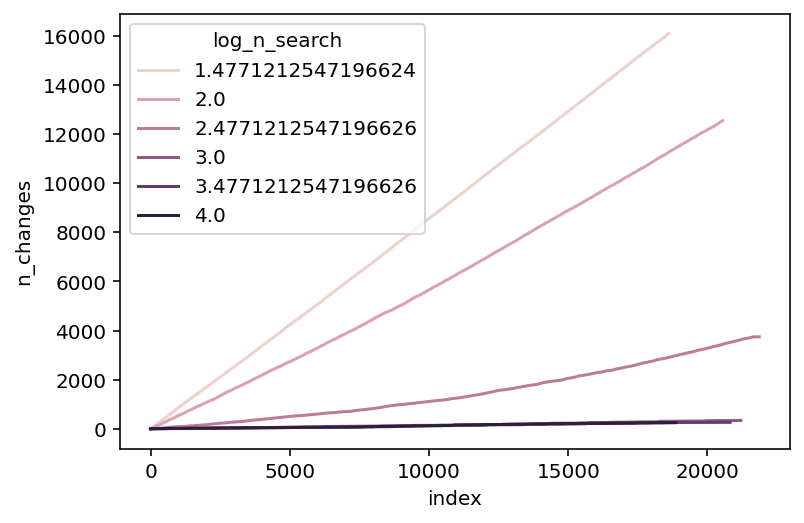

In [6]:
import seaborn as sns
show["log_n_search"] = np.log10(show["n_search"])
show = show[show.n_search <= 10_000]
ax = sns.lineplot(
    data=show,
    x="index",
    y="n_changes",
    hue="log_n_search",
    ci=None,
)
# x = np.arange(0, 20_000)
# ax.plot(x, x)
# ax.set_xlim(900, 20_000)
# ax.set_ylim(900, 20_000)
# ax.set_yscale("log")

0.013467656415694591 10000
0.012731815124435476 3000
0.6102107363605392 100
0.00718132854578097 300000
0.17126389460683408 300
0.015947157348431235 1000
0.8642884005802396 30
0.009122726490332205 100000
0.011765337917696357 30000


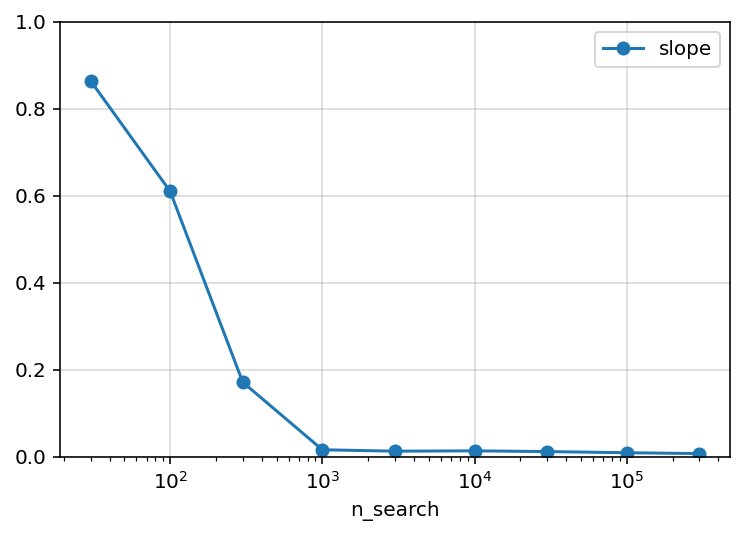

In [7]:
def _get_same_head_runs(df):
    runs = []
    for k, head in enumerate(df["head"]):
        if k == 0:
            last_head = head
            length = 0
            continue
        if head == last_head:
            length += 1
        elif head != last_head:
            runs.append(length)
            length = 0
            last_head = head
    return runs
_s = []
# print([len(])
for _df in responses:
    slope = np.mean(_df.n_changes.diff().mean())
    n_searches = _df.n_search.unique()
    assert len(n_searches) == 1
    n_search = n_searches[0]
    print(slope, n_search)
    runs = np.array(_get_same_head_runs(_df))
    _s.append({"slope": slope, "n_search": n_search,
               "runs__median": np.median(runs),
               "runs__mean": np.mean(runs),
               "runs__max": runs.max(),
               "runs__min": runs.min(),
              })

s = pd.DataFrame(_s)
s = s.sort_values(by="n_search")
ax = s.plot(x="n_search", y="slope", style="o-")
ax.set_xscale("log")
ax.set_ylim(0, 1)
ax.grid(alpha=0.5)

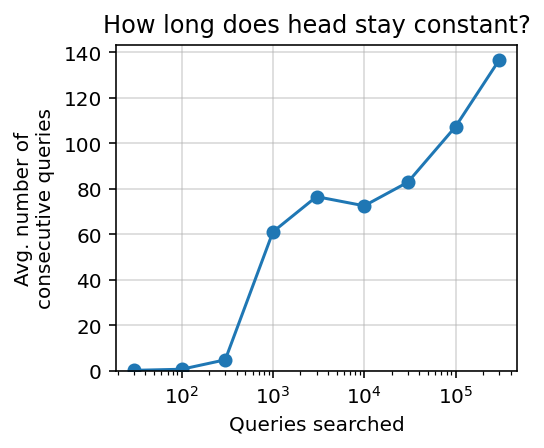

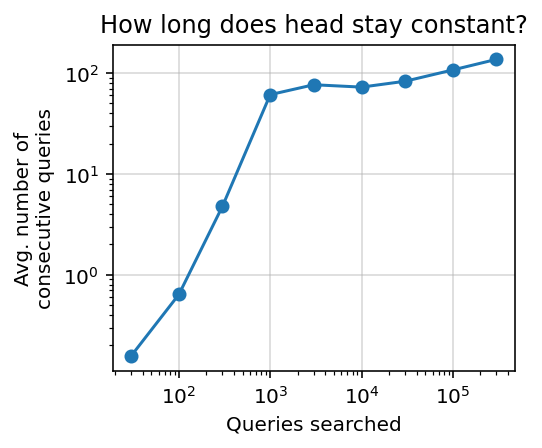

In [9]:
w = 3
for scale in ["linear", "log"]:
    fig, ax = plt.subplots(figsize=(1.2 * w, w))
    ax = s.plot(x="n_search", y="runs__mean", style="o-", ax=ax)
    ax.set_xscale("log")
    ax.grid(alpha=0.5)

    if scale == "log":
        _ = ax.set_yscale("log")
    elif scale == "linear":
        _ = ax.set_ylim(0, None)
    _ = ax.set_xlabel("Queries searched")
    _ = ax.set_ylabel("Avg. number of\nconsecutive queries")
    _ = ax.set_title("How long does head stay constant?")
    _ = ax.legend_.remove()
    fig.savefig(f"figures/n-run-{scale}.png", **save_kwargs)